In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
from util import random_matrix, Number
from lu import lu_factorization
from matinv import invert_matrix
from binet import binet

In [4]:
from tqdm import tqdm
from time import time
from threading import Thread

In [8]:
matlab_matrices = [
    random_matrix(k) for k in range(1, 200)
]
for matrix in matlab_matrices:
    np.savetxt(os.path.join("matlab_matrices", f"mat{matrix.shape[0]}.csv"), matrix, delimiter=',')

In [11]:
def compute_time(function, *args) -> float:
    start = time()
    function(*args)
    return time() - start

In [66]:
def iterate(function, matrix, counts, times, matmul_fun=binet):
    Number.purge()
    times.append(compute_time(function, matrix, matmul_fun))
    counts[0].append(Number.add_count)
    counts[1].append(Number.sub_count)
    counts[2].append(Number.mul_count)
    counts[3].append(Number.div_count)
    

def plot_times(times, **kwargs):
    plt.plot(times, linewidth=3, label="Computation times", color="blue", **kwargs)
    X = np.arange(1, len(times) + 1)
    opt = sp.optimize.curve_fit(lambda x, a, n: a * x ** n, X, times)
    a, n = opt[0][0], opt[0][1]
    plt.plot(X, a * X ** n, color='red', linestyle='--', label='Complexity fit', **kwargs)
    plt.legend(loc='best')
    plt.show()
    return a, n
    
    
def plot_flops(counts, **kwargs):
    fig, ((adds, subs), (mults, divs)) = plt.subplots(2, 2, **kwargs)
    adds.plot(counts[0], color='blue')
    adds.set_title("Addition counts")
    
    subs.plot(counts[1], color='blue')
    subs.set_title("Subtraction counts")
    
    mults.plot(counts[2], color='blue')
    mults.set_title("Multiplication counts")
    
    divs.plot(counts[3], color='blue')
    divs.set_title("Division counts")
    
    plt.show()
    
    plt.plot(flops := counts[0] + counts[1] + counts[2] + counts[3], color='blue', linewidth=3, label='FLOP count')
    X = np.arange(1, len(flops) + 1)
    opt = sp.optimize.curve_fit(lambda x, a, n: a * x ** n, X, flops)
    a, n = opt[0][0], opt[0][1]
    plt.plot(X, a * X ** n, color='red', linestyle='--', label='FLOP count fit')
    plt.legend(loc='best')
    plt.title("Flop count")
    plt.show()
    return a, n
    


def advanced_analysis(function, cap=150):
    times = []
    add_counts = []
    sub_counts = []
    mult_counts = []
    div_counts = []
    
    counts = add_counts, sub_counts, mult_counts, div_counts
    
    for matrix in tqdm(matlab_matrices[:cap]):
        iterate(function, matrix, counts, times)
        
    return times, tuple(map(np.array, counts))
    


## Matrix inversion analysis

In [63]:
times, flops = advanced_analysis(invert_matrix)

 33%|███▎      | 49/150 [00:03<00:07, 12.66it/s] 


KeyboardInterrupt: 

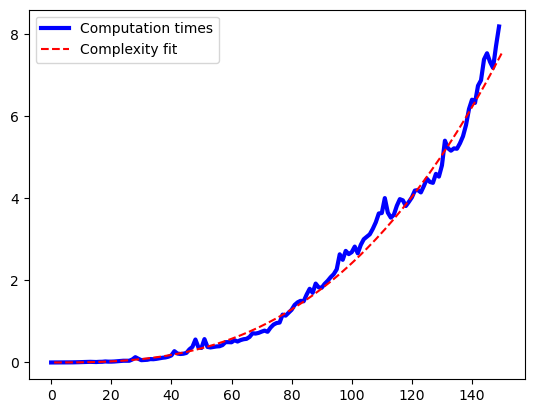

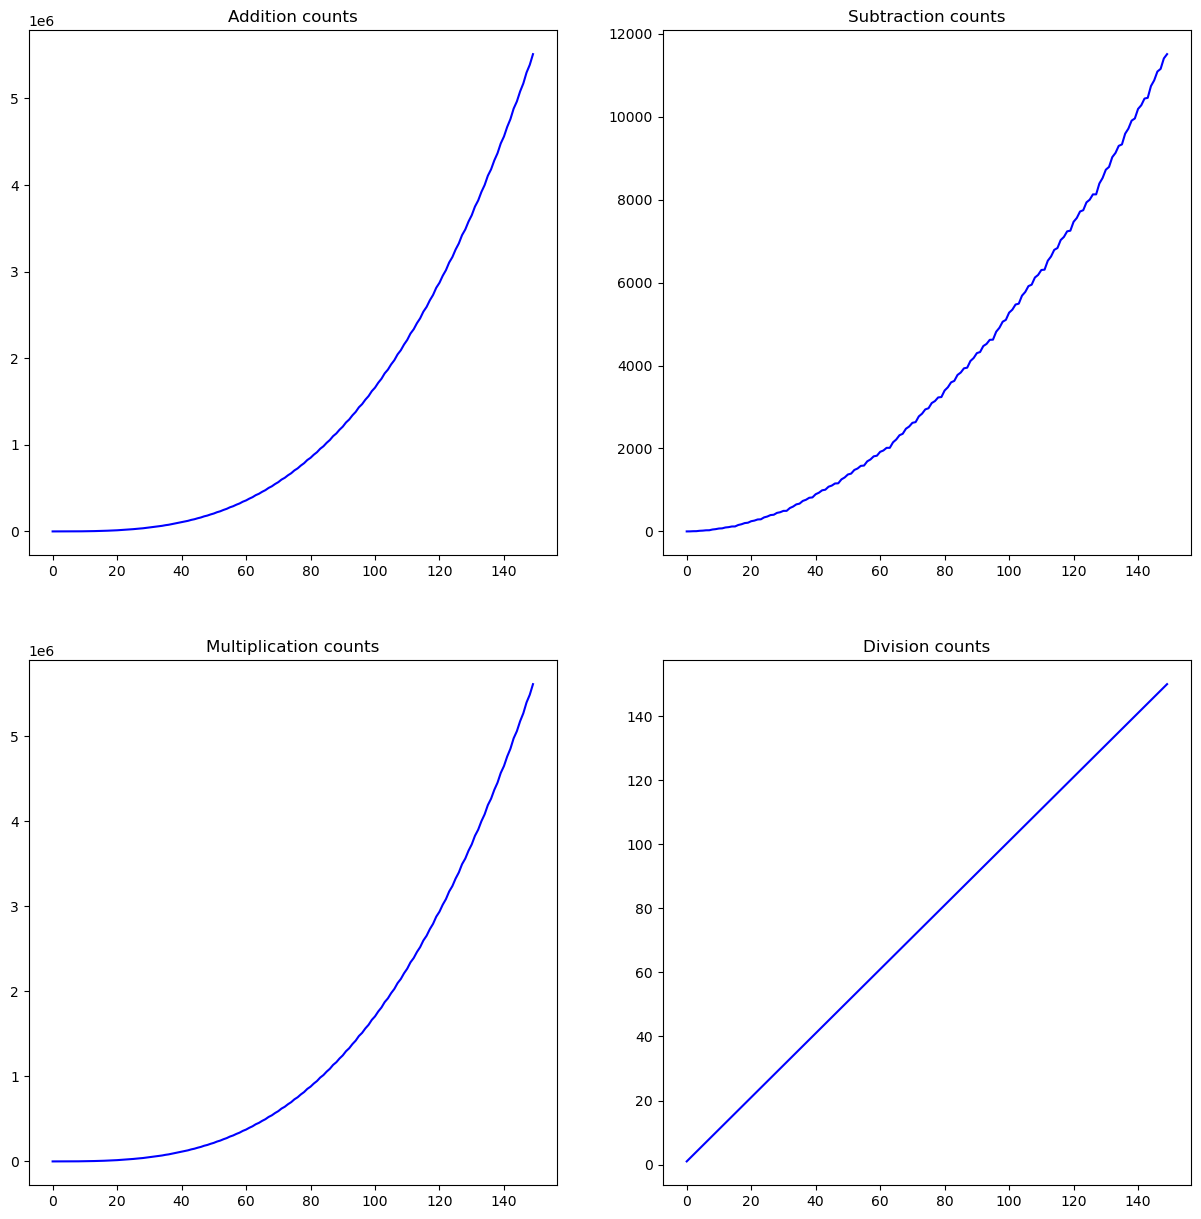

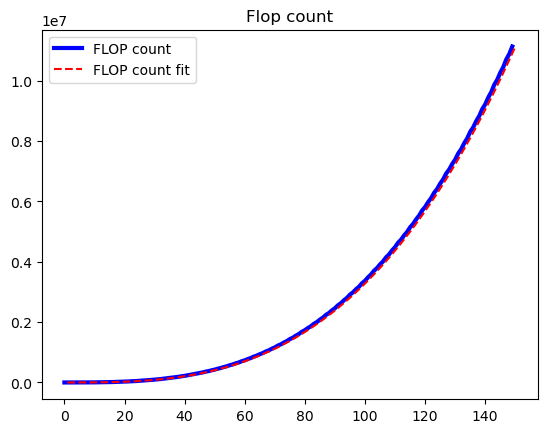

Time complexity: O(n^2.81)
Flop complexity: O(n^3.01)


In [67]:
time_curve_params = plot_times(times)
flop_curve_params = plot_flops(flops, figsize=(15, 15))

print(f"Time complexity: O(n^{time_curve_params[1]:.2f})")
print(f"Flop complexity: O(n^{flop_curve_params[1]:.2f})")

## LU factorization analysis

In [68]:
lu_times, lu_flops = advanced_analysis(lu_factorization)

100%|██████████| 150/150 [03:50<00:00,  1.54s/it]


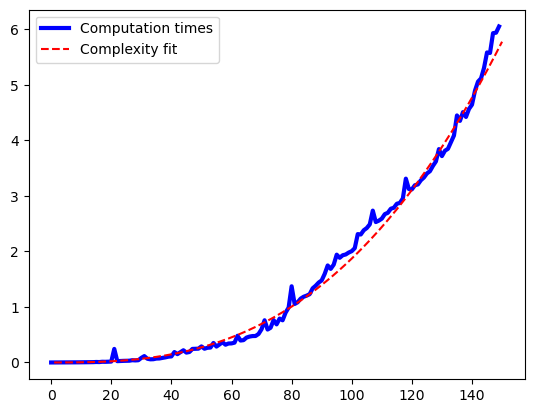

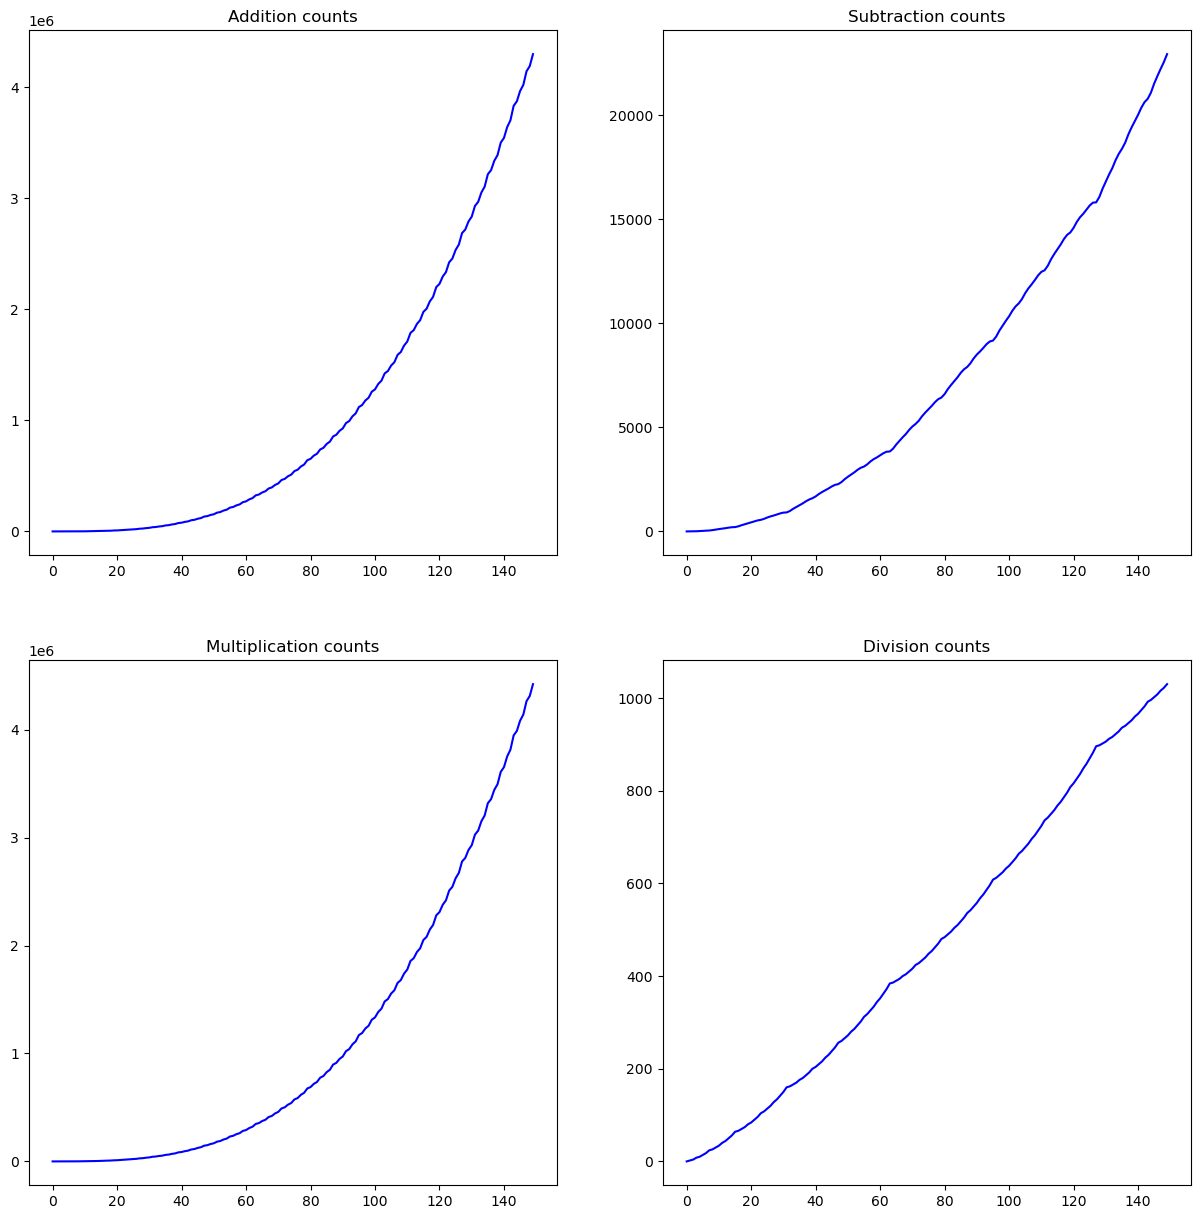

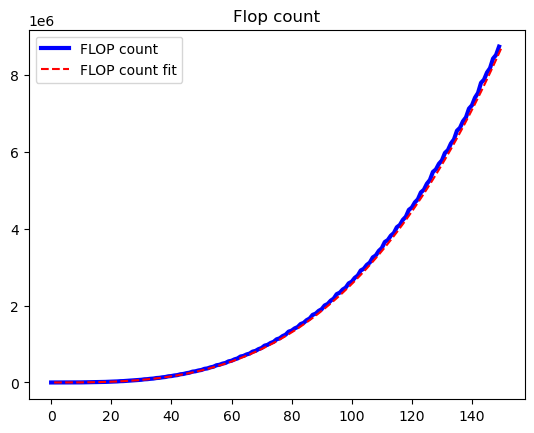

LU time complexity: O(n^2.78)
LU flop complexity: O(n^3.03)


In [69]:
lu_time_params = plot_times(lu_times)
lu_flop_params = plot_flops(lu_flops, figsize=(15, 15))
print(f"LU time complexity: O(n^{lu_time_params[1]:.2f})")
print(f"LU flop complexity: O(n^{lu_flop_params[1]:.2f})")